In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

# Data Loading

### Mount Google Drive

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download Dataset from Google Drive

In [144]:
%%capture

!pip install gdown

In [145]:
import gdown

file_id = '1WFPrMvJ9tVBP3_ulCdJn40NPpHS2r8vA'
output_filename = 'dataset.csv'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WFPrMvJ9tVBP3_ulCdJn40NPpHS2r8vA
To: /content/dataset.csv
100%|██████████| 28.8M/28.8M [00:00<00:00, 100MB/s] 


'dataset.csv'

### Load Dataset

In [146]:
df = pd.read_csv('./dataset.csv')

df.head()

,id,code,content,image_url,latitude,longitude,status,category,zone,village,district,city,province,created_at
0,b0906c9a-e3e3-410b-b918-1fa77438563b,JK2401070247,Saya membuat laporan EM231211BDKB tanggal 12 D...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.176120,106.868300,Selesai,Gangguan dan Kebisingan,SATUAN POLISI PAMONG PRAJA KOTA ADM JAKARTA PUSAT,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH,JAKARTA PUSAT,DKI JAKARTA,2024-01-07T07:10:58.900Z
1,800d8988-3036-4360-b292-77f5ba6bb946,JK2401050479,"Jalan amblas, sudah banyak korban. \nAkibat pe...",https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.281803,106.771948,Selesai,Jalan,SUDIN SUMBER DAYA AIR JAKARTA SELATAN,PONDOK PINANG,KEBAYORAN LAMA,JAKARTA SELATAN,DKI JAKARTA,2024-01-05T15:27:53.040Z
2,ee1af07a-dc67-4846-9661-ea0c20d1ef08,JK2401100152,"terdapat lubang cukup dalam, atas perhatian da...",https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.223766,106.823427,Selesai,Jalan,UNIT PERALATAN DAN PERBEKALAN BINA MARGA,KARET KUNINGAN,SETIA BUDI,JAKARTA SELATAN,DKI JAKARTA,2024-01-10T02:38:47.276Z
3,00c83eee-78b5-4749-af46-d17a5e388aa8,JK2401070277,Segera tindak lanjuti masalah hujan lebat dari...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.302330,106.816300,Selesai,Penanganan Banjir,KELURAHAN RAGUNAN,RAGUNAN,PASAR MINGGU,JAKARTA SELATAN,DKI JAKARTA,2024-01-07T08:08:15.210Z
4,ca8a4b6f-21a8-4228-b428-8ad57042775d,JK2401070267,Mohon permohonan peninggian jembatan dan pemba...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.266710,106.832800,Selesai,Jalan,KELURAHAN KALIBATA,KALIBATA,PANCORAN,JAKARTA SELATAN,DKI JAKARTA,2024-01-07T07:38:14.759Z


### Take the only relevants column

In [147]:
df.index = df['id']
df = df[['content', 'category']]

df.head()

,content,category
id,,
b0906c9a-e3e3-410b-b918-1fa77438563b,Saya membuat laporan EM231211BDKB tanggal 12 D...,Gangguan dan Kebisingan
800d8988-3036-4360-b292-77f5ba6bb946,"Jalan amblas, sudah banyak korban. \nAkibat pe...",Jalan
ee1af07a-dc67-4846-9661-ea0c20d1ef08,"terdapat lubang cukup dalam, atas perhatian da...",Jalan
00c83eee-78b5-4749-af46-d17a5e388aa8,Segera tindak lanjuti masalah hujan lebat dari...,Penanganan Banjir
ca8a4b6f-21a8-4228-b428-8ad57042775d,Mohon permohonan peninggian jembatan dan pemba...,Jalan


In [148]:
df['content'].iloc[4]

'Mohon permohonan peninggian jembatan dan pembangunan tanggul pelindung digubris agar tidak ada korban jiwa lagi.'

# Exploratory Data Analysis

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53898 entries, b0906c9a-e3e3-410b-b918-1fa77438563b to e18199f0-79be-42ae-8402-6ed5d108ddc0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   53898 non-null  object
 1   category  53898 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [150]:
len(df['category'].unique())

68

### WordCloud

In [151]:
from wordcloud import WordCloud

text_combined = " ".join(s for s in df['content']).lower()

In [152]:
wc = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    min_font_size=10,
    max_font_size=150,
    colormap='viridis',
    random_state=42
).generate(text_combined)

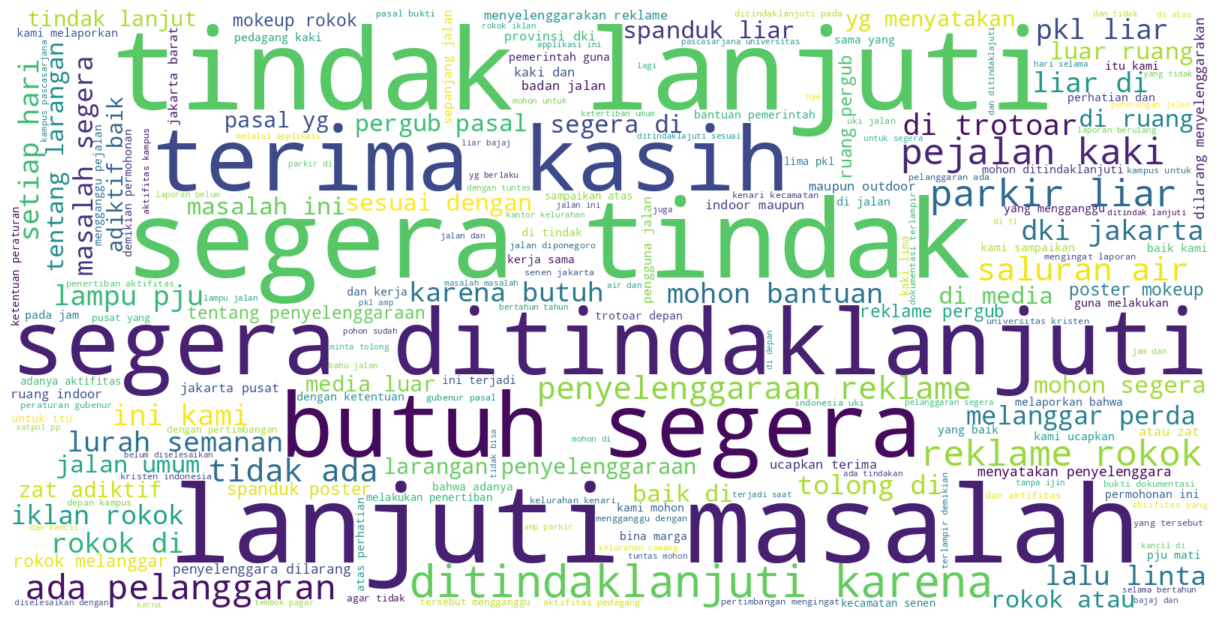

In [153]:
plt.figure(figsize=(12, 6), facecolor=None)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Check for Copy-paste Spammer

In [154]:
df['content'].duplicated().sum()

np.int64(13234)

In [155]:
df[df['content'].duplicated()].head()

,content,category
id,,
96f3308d-59f6-4297-ad8c-dda0218d7553,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik
4d6f9bbe-3050-4eae-ba97-a1348867b780,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik
34783036-df1d-4184-b84f-7b50a6ab3a03,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik
ca536f86-0af9-43e3-878c-668386791b52,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik
8516b374-2b72-4d5e-b981-b7589e255ba3,PKL liar menggunakan fasum untuk berdagang\n\n...,PKL Liar


Oke, data kita so-far banyak spammer copy-paste. Jadi kita harus filtering spammer-spammer ini.

### Data Distributions

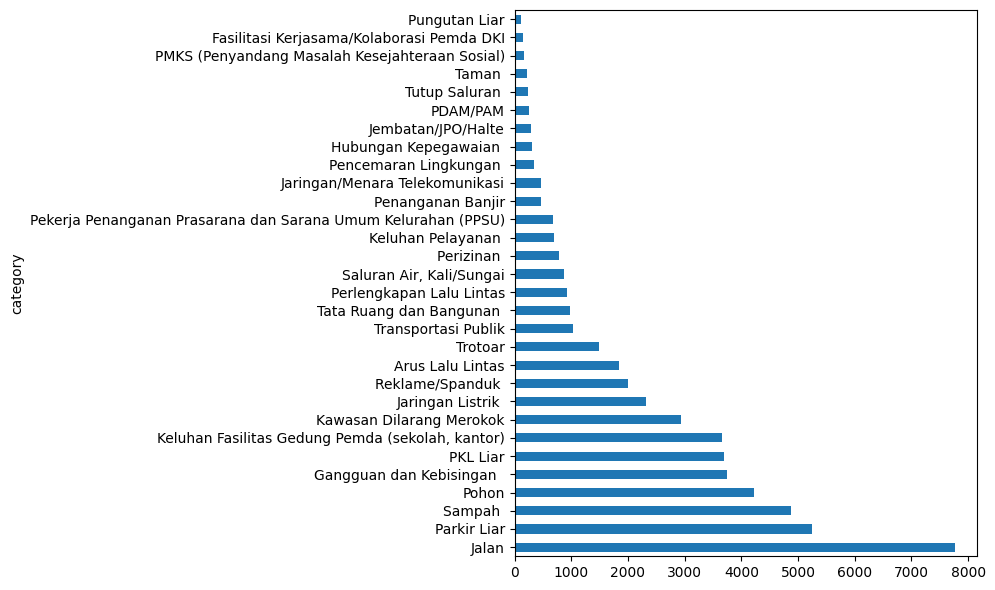

In [156]:
plt.figure(figsize=(10, 6))
df['category'].value_counts().head(30).plot(kind='barh')
plt.tight_layout()
plt.show()

Disini distribusi kategori cenderung tidak imbang, sehingga kalau kita pakai metode supervised learning buat generate label based on text, model bakal cenderung bias ke arah label mayoritas. Makanya, perlu approach yang lebih efektif buat handling bias ini, jadi kita bakal pakai metode unsupervised buat generate label bersamaan dengan hidden sub-topic based on text laporan yang dibuat pada kolom 'content'.

### Noise Analysis

- Word Count Analysis of each content (panjang rata-rata laporan warga buat semua kategori)

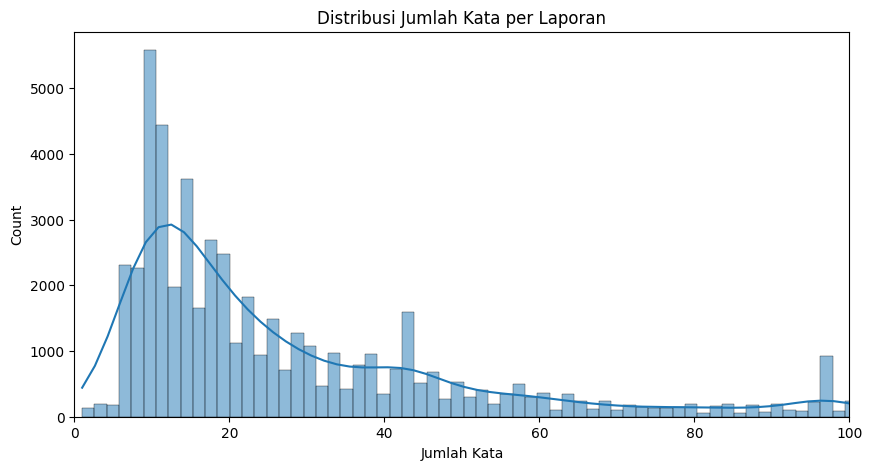

In [157]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], kde=True)
plt.title('Distribusi Jumlah Kata per Laporan')
plt.xlabel('Jumlah Kata')
plt.xlim(0, 100)
plt.show()

- Summary Statistics of Word Count

In [158]:
df['word_count'].describe().T

,word_count
count,53898.000000
mean,33.756373
std,37.195414
min,1.000000
25%,12.000000
50%,20.000000
75%,42.000000
max,328.000000


Kita bisa liat ada noise di data yang ditunjukkan oleh adanya laporan yang hanya tersusun dari 1 kata aja.

In [159]:
df[df['word_count'] == 1]['content']

,content
id,
0afe224b-40bd-4be6-94d9-376385d23c48,Padam............................................
38db9e7a-aa9a-4b16-b393-4ead509ff083,Amblazzzzzzzzzz..................................
f21dfe10-be87-4f34-be06-780789f012a1,corli............................................
096b8c30-3ebf-4c9a-8917-4f8e115b8f82,#sampah
a7ea39ae-0248-4603-8968-bc26be46c3f7,ftijjhhdswehjkklluewawwyjjfdswwfghuuuuijjkkkkk...
85560c54-3ecc-48d1-9422-646a9e1ead06,sampahhhhhh......................................
33eda650-90e6-4b35-b5ac-747d5d6c5b8e,ghsiiejdjdjdjdjdjdkdkddkhshsjsjakasklssusjjsnx...
c170d72a-03de-4a31-af06-c717eb108284,odbdidfnrkgkggjfksjsbsvwuabsoaxvheekssnsjsisna...
2e356bcd-64e4-4f49-825b-9085269f6278,vfhhhderghhgrethheethhheerrthxcjjnvxwsshjnbsss...


Diatas terlihat bahwa laporan-laporan yang dibuat adalah laporan yang basically bisa kita anggap sebagai noise karena laporan jenis ini tidak akan memiliki `semantics context` yang cukup buat model kita untuk bekerja secara efektif. Jadi, kita harus ngelakuin filtering di bagian data preprocessing terhadap data dengan word count yang sedikit.

# Data Preprocessing

In [160]:
%%capture

!pip install Sastrawi

In [161]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Text Cleaning

In [162]:
list_stopwords = set(stopwords.words('indonesian'))

In [163]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [164]:
def clean_text(text):
    # Ubah jadi lowercase
    text = str(text).lower()

    # Hapus URL
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Hapus Mentions & Hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Hapus dengan angka dan simbol
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Hapus Emoji & Simbol Aneh (ganti dgn spasi)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    cleaned_tokens = []

    # Stopwords removal
    tokens = word_tokenize(text)
    for word in tokens:
      # Kalau token bukan merupakan sebuah stopwords
      if word not in list_stopwords:
        # Lakuin stemming (Nemu library ini -> "memperbaiki" = "baik")
        # stemmed_word = stemmer.stem(word)
        cleaned_tokens.append(word)

    return " ".join(cleaned_tokens)

In [165]:
df['clean_content'] = df['content'].apply(clean_text)

#### Before and After df['content'] text cleaning.

In [166]:
for i in range(1, 5+1):
  print("Uncleaned Text:")
  print(df['content'][i])

  print("Cleaned Text:")
  print(df['clean_content'][i])

  print("\n")

Uncleaned Text:
Jalan amblas, sudah banyak korban. 
Akibat pekerjaan gorong-gorong kerjanya sembarangan
Cleaned Text:
jalan amblas korban akibat pekerjaan gorong gorong kerjanya sembarangan


Uncleaned Text:
terdapat lubang cukup dalam, atas perhatian dan perbaikannya saya ucapkan terima kasih
Cleaned Text:
lubang perhatian perbaikannya ucapkan terima kasih


Uncleaned Text:
Segera tindak lanjuti masalah hujan lebat dari jam 12.00 wib  hingga 14.00 wib menyebabkan jalanan langsung banjir dibawah lutut orang dewasa.
Cleaned Text:
tindak lanjuti hujan lebat jam wib wib menyebabkan jalanan langsung banjir dibawah lutut orang dewasa


Uncleaned Text:
Mohon permohonan peninggian jembatan dan pembangunan tanggul pelindung digubris agar tidak ada korban jiwa lagi.
Cleaned Text:
mohon permohonan peninggian jembatan pembangunan tanggul pelindung digubris korban jiwa


Uncleaned Text:
Penutup got hancur, tolong diperbaiki. Butuh segera ditindaklanjuti karena satu satunya akses warga ( gang buntu

- Change `df['content']` to `df['cleaned_content']`

In [167]:
df['content'] = df['clean_content']

### Delete Copy-Paste Spammer

In [168]:
initial_count = len(df)
df = df.drop_duplicates(subset=['clean_content'])

In [169]:
df['content'].duplicated().sum()

np.int64(0)

### Delete Noise (Laporan warga yang cuman 1 kata (ga-detailed))

In [170]:
df = df[df['word_count'] >= 4].copy()

In [171]:
df['word_count'].describe()

,word_count
count,39099.000000
mean,29.626947
std,32.299432
min,4.000000
25%,12.000000
50%,19.000000
75%,34.000000
max,328.000000


### Delete NaN values

In [172]:
df.isna().sum()

,0
content,0
category,0
word_count,0
clean_content,0


In [174]:
df = df.dropna(subset=['content'])

df['content'] = df['content'].astype(str)

df = df[df['content'].str.strip() != ""]

### Simpen ke .csv biar cepet kalau mau re-training notebook.

In [175]:
df.columns

Index(['content', 'category', 'word_count', 'clean_content'], dtype='object')

In [176]:
df = df[['content', 'category']]

df.to_csv('cleaned_dataset.csv', index=False)

### Final Results on Cleaned Dataset

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, b0906c9a-e3e3-410b-b918-1fa77438563b to e18199f0-79be-42ae-8402-6ed5d108ddc0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   39098 non-null  object
 1   category  39098 non-null  object
dtypes: object(2)
memory usage: 916.4+ KB


Setelah Filtering dkk, dataset kita dari 53898 jadi sisa 39816 baris.

# Fine-Tuning (IndoBERT)

In [178]:
%%capture

!pip install sentence-transformers

In [179]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, models, losses, datasets
import gc
import os

# biar ga diminta Login pas Fine Tuning
os.environ["WANDB_MODE"] = "disabled"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [180]:
gc.collect()
torch.cuda.empty_cache()

In [181]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

- Reload cleaned csv

In [182]:
df = pd.read_csv('cleaned_dataset.csv')

df.head()

,content,category
0,laporan em bdkb tanggal desember em c j tangga...,Gangguan dan Kebisingan
1,jalan amblas korban akibat pekerjaan gorong go...,Jalan
2,lubang perhatian perbaikannya ucapkan terima k...,Jalan
3,tindak lanjuti hujan lebat jam wib wib menyeba...,Penanganan Banjir
4,mohon permohonan peninggian jembatan pembangun...,Jalan


In [183]:
X = df['content'].tolist()

### TSDAE (Transformer-based Sequential Denoising Auto-Encoder)

Denoising AutoEncoder (Model belajar menebak kalimat asli dari kalimat yang dirusak dengan diberi noise)

Ini contoh metode fine-tuning dengan tujuan supaya model kita bisa ubah text kita ke vector embedding yang benar-benar merepresentasikan text tersebut.

- Load Model (IndoBERT)

In [184]:
word_embedding_model = models.Transformer('indobenchmark/indobert-base-p1', max_seq_length=128)

- Tambahin Pooling Layer

In [185]:
# tambahin pooling layer
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

In [186]:
# gabungin
model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

- Create a training data (Convert sentences into Sentence_transformers Input Example Data Types)

In [187]:
train_dataset = datasets.DenoisingAutoEncoderDataset(X)

- Convert it into DataLoader

In [188]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

- Specify Loss Function: TSDAE menggunakan DenoisingAutoEncoderLoss

In [189]:
train_loss = losses.DenoisingAutoEncoderLoss(
    model,
    tie_encoder_decoder=True
)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.b

In [ ]:
# Start Fine-Tuning (Retraining Pretrained IndoBERT Model into our Dataset)
history = model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=False,
    use_amp=True
)

# Text Representation

In [191]:
embeddings = model.encode(
    X,
    batch_size=32,
    show_progress_bar=False,
    device=device,
    convert_to_numpy=True,
    normalize_embeddings=True
)

- Store Embedding Vector Results

Biar tar kalau mau ulang training atau runtime T4 Colab abis gaush Retrain, tapi pake aja via Embedding Vectornya.

In [192]:
# store results
os.makedirs('output')

# Simpan embedding vector (dalam bentuk numpy) & metadata laporan
np.save('output/embeddings_indobert.npy', embeddings)
df.to_csv('output/metadata_laporan.csv', index=False)

# Model Interpretation

Ini cuman buat ngecek gimana proses + visualisasi text ke contextual embeddingnya via IndoBERT.

### Install & Import Libraries

In [201]:
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel

### Configuration (GPU and Evaluation Mode)

In [202]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

### Ambil 1000 sample

In [203]:
df_sample = df.sample(n=1000, random_state=42).reset_index(drop=True)

texts = df_sample['content'].tolist()
labels = df_sample['category'].tolist() # <- buat misal aja karena kita belum generate

In [204]:
df_sample['content'] = df_sample['content'].astype(str)

### Embedding Extraction

In [218]:
high_dim_embeddings = model.encode(texts, batch_size=32, show_progress_bar=False)

- buat cross-check aja

In [214]:
high_dim_embeddings.shape

(1000, 768)

### Dimensionality Reduce (buat visualisasi)

In [215]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
low_dim_embeddings = tsne.fit_transform(high_dim_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 6.136038
[t-SNE] KL divergence after 100 iterations with early exaggeration: 68.986076
[t-SNE] KL divergence after 1000 iterations: 1.289220


### Visualisasi Vector Embedding

In [216]:
df_tsne = pd.DataFrame({
    'tsne_x': low_dim_embeddings[:, 0],
    'tsne_y': low_dim_embeddings[:, 1],
    'Category': labels
})

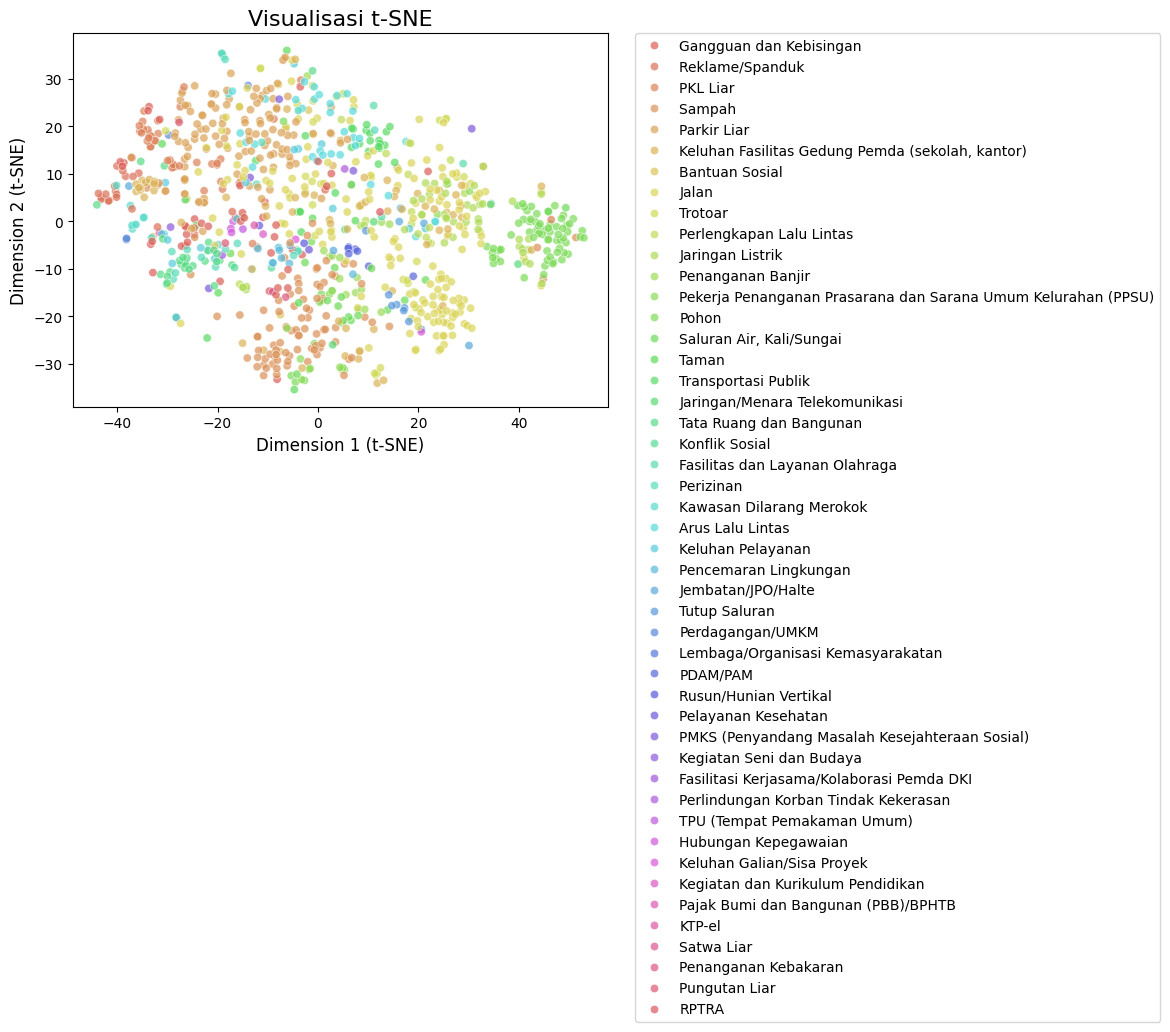

In [217]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue='Category',
    palette=sns.color_palette("hls", len(set(labels))),
    data=df_tsne,
    legend="full",
    alpha=0.7
)

plt.title('Visualisasi t-SNE', fontsize=16)
plt.xlabel('Dimension 1 (t-SNE)', fontsize=12)
plt.ylabel('Dimension 2 (t-SNE)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('tsne_visualization_indobert.png', dpi=300)
plt.show()

# Graph Construction

In [260]:
%%capture

!pip install python-louvain networkx

In [261]:
import networkx as nx
import community.community_louvain as community_louvain

### Data Reloading

In [262]:
embeddings = np.load('output/embeddings_indobert.npy')
df = pd.read_csv('output/metadata_laporan.csv')

### Threshold

Logika simpelnya, when similarity hasil dari cosine similarity > threshold, buat edgesnya di graphnya

In [263]:
THRESHOLD = 0.95

### Graph Initialization

In [264]:
# buat graph tanpa edges (buat nodesnya doang sebanyak panjang dataset kita)
G = nx.Graph()
num_nodes = len(df)
G.add_nodes_from(range(len(df)))

### Cosine Similarity

In [ ]:
batch_size = 1000
for i in range(0, num_nodes, batch_size):
    # ambil data per batch
    batch_emb = embeddings[i:min(i + batch_size, num_nodes)]

    # hitung similarity batch vs semua data-nya
    sim_matrix = cosine_similarity(batch_emb, embeddings)

    # filter sim_matrix > threshold, catet index buat setiap sim_matrix yang similarity-nya diatas threshold
    rows, cols = np.where(sim_matrix > THRESHOLD)

    for r, c in zip(rows, cols):
        # tambahin edge-nya di graph dengan weight dari similaritynya.
        if i + r < c:
            weight = sim_matrix[r, c]
            G.add_edge(i + r, c, weight=weight)

### Final Graph

In [ ]:
print(f"Jumlah Nodes: {G.number_of_nodes()}")
print(f"Jumlah Edges: {G.number_of_edges()}")

### Plot

In [ ]:
# Todo-list

# Louvain Algorithm

Clustering nodes yang ada di graph. Clustering dilakukan terhadap seberapa rapat node-node saling terhubung di dalam cluster dibanding antar-cluster.

- **Node yang banyak edge similarity tinggi** bakal **masuk cluster yang sama**.

### Graph Clustering

In [ ]:
partition = community_louvain.best_partition(G, resolution=1.0, random_state=42)

### Mapping (Ubah jadi cluster-cluster)

In [ ]:
df['cluster'] = df.index.map(partition)

In [ ]:
df['cluster'].nunique()

In [ ]:
output_file = 'output/laporan_warga_clustered.csv'
df.to_csv(output_file, index=False)

# Topic Extraction (TF-IDF)

- Ambil laporan yang udah clustered

In [ ]:
df = pd.read_csv('output/laporan_warga_clustered.csv')

### Data Grouping (by Cluster)

In [ ]:
docs_per_class = df.groupby(['cluster'], as_index=False).agg({'content': ' '.join})

In [ ]:
docs_per_class.head()

### TF-IDF (Keyword Extractor)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=id_stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(docs_per_class['content'])
feature_names = tfidf_vectorizer.get_feature_names_out()

### Top-5 Keywords Extractions

Dari banyaknya keyword yang di-extract, ambil 1 aja.

In [ ]:
top_n_words = 5 # jaga-jaga aja, tetep ambil top 5 (siapa tau gaada top 1 bisa ambil top 2 wkwkwk)
cluster_labels = {}

In [ ]:
for i in range(len(docs_per_class)):
    cluster_id = docs_per_class.iloc[i]['cluster']

    row = tfidf_matrix[i].toarray().flatten()
    top_indices = row.argsort()[-top_n_words:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]

    final_label = top_features[:top_n_words] if len(top_features) > 0 else "unknown"

    cluster_labels[cluster_id] = final_label

### Mapping

In [ ]:
df['topic_label'] = df['cluster'].map(cluster_labels)

In [ ]:
df.head()

### Simpen lagi ke .csv

In [ ]:
output_file = 'output/final_laporan_warga_labeled.csv'
df.to_csv(output_file, index=False)

# Evaluation I (Silhouette Score)

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
def compute_silhouette(embeddings, cluster_labels, texts=None, sample_limit=5000, metric='cosine', random_state=42):
    n = len(cluster_labels)
    unique_clusters = np.unique(cluster_labels)

    # optionally subsample to limit cost
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=sample_limit, replace=False)
    emb = embeddings[idx]
    labels = np.array(cluster_labels)[idx]
    texts_sample = [texts[i] for i in idx] if texts is not None else None
    used_idx = idx

    # compute global silhouette
    global_sil = silhouette_score(emb, labels, metric=metric)

    # compute silhouette for each sample
    sample_sil = silhouette_samples(emb, labels, metric=metric)

    # per-cluster mean silhouette
    per_cluster = {}
    for c in np.unique(labels):
        mask = labels == c
        per_cluster[c] = float(np.mean(sample_sil[mask]))

    per_cluster_series = pd.Series(per_cluster).sort_values(ascending=False)

    # gather sample dataframe for inspection
    sample_df = pd.DataFrame({
        'index': used_idx,
        'cluster': labels,
        'silhouette': sample_sil
    })

    if texts_sample is not None:
        sample_df['text'] = texts_sample

    # produce silhouette plot
    _plot_silhouette(sample_sil, labels, global_sil, title=f"Silhouette Plot (global = {global_sil:.4f})")

    return {
        'global_score': float(global_sil),
        'per_cluster_scores': per_cluster_series,
        'sample_df': sample_df
    }

In [ ]:
def _plot_silhouette(sample_sil, labels, global_sil, figsize=(10,6)):
    plt.figure(figsize=figsize)
    y_lower = 10
    clusters = np.unique(labels)
    n_clusters = len(clusters)

    # sort clusters by silhouette mean for nicer plot
    order = sorted(clusters, key=lambda c: sample_sil[labels==c].mean(), reverse=True)
    for i, c in enumerate(order):
        sil_vals = sample_sil[labels == c]
        sil_vals.sort()
        size_cluster = len(sil_vals)
        y_upper = y_lower + size_cluster
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster, str(c))
        y_lower = y_upper + 10  # 10 for spacing

    plt.axvline(x=global_sil, color="red", linestyle="--", label=f"Global Silhouette = {global_sil:.3f}")
    plt.xlabel("Silhouette coefficient")
    plt.ylabel("Cluster (ordered by mean silhouette)")
    plt.title("Silhouette Plot")
    plt.legend()
    plt.xlim([-0.2, 1])
    plt.tight_layout()
    plt.show()

In [ ]:
embeddings = np.array(embeddings)
labels = df["cluster"].astype(int).values

In [ ]:
global_score = silhouette_score(embeddings, labels)

In [ ]:
sample_sil = silhouette_samples(embeddings, labels, metric='cosine')

df["silhouette"] = sample_sil

In [ ]:
cluster_scores = df.groupby("cluster")["silhouette"].mean().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df["silhouette"], bins=40, kde=True)
plt.axvline(global_score, color='red', linestyle='--', label=f"Mean = {global_score:.3f}")
plt.title("Silhouette Distribution Across All Document Clusters")
plt.xlabel("Silhouette Score")
plt.legend()
plt.show()

# Zero-Shot Classification

In [245]:
from transformers import pipeline

In [ ]:
MODEL_NAME = "w11wo/indonesian-roberta-base-indonli"

zs = pipeline("zero-shot-classification", model=MODEL_NAME, device=0)

In [ ]:
candidate_labels = [
    "jalan rusak", "banjir", "pohon tumbang", "kebisingan",
    "sampah", "lampu jalan mati", "kebakaran", "parkir liar",
    "saluran tersumbat", "kerusakan drainase", "bahaya", "trotoar",
    "rokok", "polusi", "macet"
]

In [ ]:
def evaluate_cluster_with_indonli(df, labels=None, samples_per_cluster=30):
    if labels is None:
        raise ValueError("Anda harus memberi candidate_labels.")

    results = {}
    clusters = df['cluster'].unique()

    print(f"Evaluating {len(clusters)} clusters...\n")

    for c in tqdm(clusters, desc="Cluster", unit="cluster"):
        docs = df[df['cluster'] == c]['content'].dropna()
        if len(docs) == 0:
            continue

        sample = docs.sample(min(samples_per_cluster, len(docs)), random_state=42).tolist()

        top_preds = []
        top_scores = []

        pb = tqdm(sample, desc=f"Cluster {c}", unit="doc", leave=False)

        for text in pb:
            out = zs(text, candidate_labels=labels, multi_label=False)

            pred_label = out['labels'][0]
            pred_score = out['scores'][0]

            top_preds.append(pred_label)
            top_scores.append(pred_score)

        cnt = Counter(top_preds)
        top_label, top_count = cnt.most_common(1)[0]
        consistency = top_count / len(top_preds)
        avg_conf = np.mean(
            [s for p, s in zip(top_preds, top_scores) if p == top_label]
        )

        results[c] = {
            'n_docs': len(docs),
            'n_sample': len(sample),
            'top_label': top_label,
            'consistency': float(consistency),
            'avg_confidence': float(avg_conf),
        }

    return results

In [ ]:
df = pd.read_csv("output/final_laporan_warga_labeled.csv")

candidate_labels = [
    "jalan rusak", "banjir", "pohon tumbang", "kebisingan",
    "sampah", "lampu jalan mati", "kebakaran", "parkir liar",
    "saluran tersumbat", "drainase rusak"
]

evaluation = evaluate_cluster_with_indonli(df, labels=candidate_labels, samples_per_cluster=25)

evaluation

In [ ]:
pd.DataFrame.from_dict(evaluation, orient='index') \
  .reset_index() \
  .rename(columns={'index': 'cluster'}) \
  .to_csv("./output/cluster_zero_shot_eval.csv", index=False)

# Evaluation II

In [ ]:
# Todo-list